# Import Libraries 


In [3]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 24.1 MB/s 


In [4]:
## EDA libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import shap

## feature engineering libraries
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split

## model preparation libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

## model evaluation libraries
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold

## model hyperparameter tuning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import joblib
%matplotlib inline

# Import Data And Preprocessing

According to data dictionary, we have 3 unknown fields, **fruitset, fruitmass, seeds** having high correlation values with the target varialble, the **yield** value.

1. we have a data dictionary of mutual correlated values of each of the fields with yield values
2. as this clearly is a regression problem, we can perform feature selection on the data
3. there are the following approaches:
    * f_regression() parameter for selecting by correlation
    * mutual_info_regression() for selecting by information gain
    * raw data features kept intact

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
berry_data = pd.read_csv('/content/drive/MyDrive/data/WildBlueberryPollinationSimulationData.csv')
berry_data.head(20)

,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.410652,0.408159,31.678898,3813.165795
1,1,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,1.0,0.10,0.444254,0.425458,33.449385,4947.605663
2,2,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,16.0,0.26,0.383787,0.399172,30.546306,3866.798965
3,3,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.407564,0.408789,31.562586,4303.943030
4,4,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.354413,0.382703,28.873714,3436.493543
5,5,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,34.0,0.56,0.309669,0.366284,27.345454,2825.003738
6,6,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,24.0,0.39,0.284443,0.352186,26.101179,2625.269164
7,7,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,34.0,0.56,0.246568,0.342826,25.042361,2379.905214
8,8,37.5,0.75,0.25,0.25,0.25,77.4,46.8,64.7,55.8,27.0,45.8,16.0,0.26,0.427977,0.414711,32.334153,4234.868585
9,9,37.5,0.75,0.25,0.25,0.25,77.4,46.8,64.7,55.8,27.0,45.8,1.0,0.10,0.464366,0.436346,34.849953,5356.871861


In [7]:
berry_data.shape

(777, 18)

In [8]:
berry_data.isna().sum()

Row#                    0
clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

In [9]:
berry_data.describe()

,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000
mean,388.000000,18.767696,0.417133,0.282389,0.468817,0.562062,82.277091,49.700515,68.723037,59.309395,28.690219,48.613127,18.309292,0.320000,0.502121,0.445983,36.122432,6012.849165
std,224.444871,6.999063,0.978904,0.066343,0.161052,0.169119,9.193745,5.595769,7.676984,6.647760,3.209547,5.417072,12.124226,0.171279,0.079445,0.040333,4.377889,1356.955318
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.192732,0.311921,22.079199,1637.704022
25%,194.000000,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,3.770000,0.100000,0.454725,0.416281,33.116091,5124.854901
50%,388.000000,12.500000,0.250000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.508297,0.445587,36.166044,6107.382466
75%,582.000000,25.000000,0.500000,0.380000,0.630000,0.750000,89.000000,52.000000,71.900000,66.000000,30.000000,50.800000,24.000000,0.390000,0.561297,0.476149,39.239668,7022.189731
max,776.000000,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.585105,8969.401842


In [10]:
berry_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Row#                  777 non-null    int64  
 1   clonesize             777 non-null    float64
 2   honeybee              777 non-null    float64
 3   bumbles               777 non-null    float64
 4   andrena               777 non-null    float64
 5   osmia                 777 non-null    float64
 6   MaxOfUpperTRange      777 non-null    float64
 7   MinOfUpperTRange      777 non-null    float64
 8   AverageOfUpperTRange  777 non-null    float64
 9   MaxOfLowerTRange      777 non-null    float64
 10  MinOfLowerTRange      777 non-null    float64
 11  AverageOfLowerTRange  777 non-null    float64
 12  RainingDays           777 non-null    float64
 13  AverageRainingDays    777 non-null    float64
 14  fruitset              777 non-null    float64
 15  fruitmass             7

In [11]:
berry_data.nunique()

Row#                    777
clonesize                 6
honeybee                  7
bumbles                  10
andrena                  12
osmia                    12
MaxOfUpperTRange          5
MinOfUpperTRange          5
AverageOfUpperTRange      5
MaxOfLowerTRange          5
MinOfLowerTRange          5
AverageOfLowerTRange      5
RainingDays               5
AverageRainingDays        5
fruitset                777
fruitmass               777
seeds                   777
yield                   777
dtype: int64

# Univariate Analysis
<p style="font-size: 17px;"> We have no null values, and overall dtype of the dataset is <b>float</b> So the next step will be Preprocessing </p>

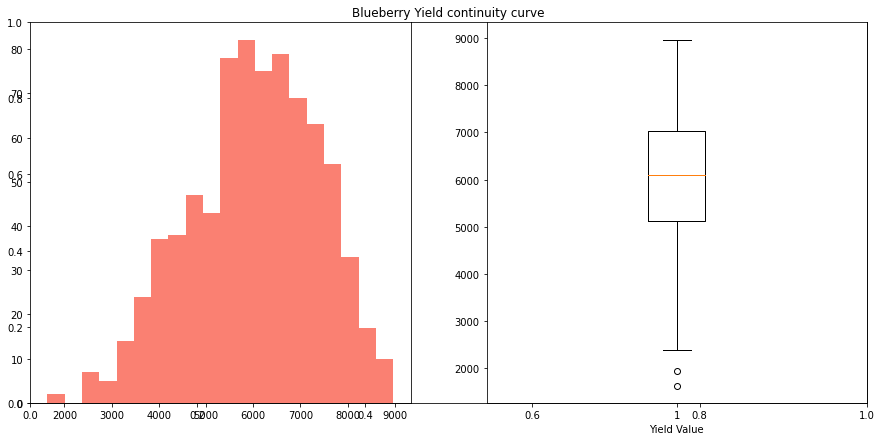

In [12]:
figs = plt.figure(figsize=(15,7))
plt.title("Blueberry Yield continuity curve")
ax1 = figs.add_subplot(121)
ax2 = figs.add_subplot(122)
x = berry_data["yield"]
plt.xlabel("Yield Value")
ax1.hist(x, bins=20, color="salmon")
ax2.boxplot(x);

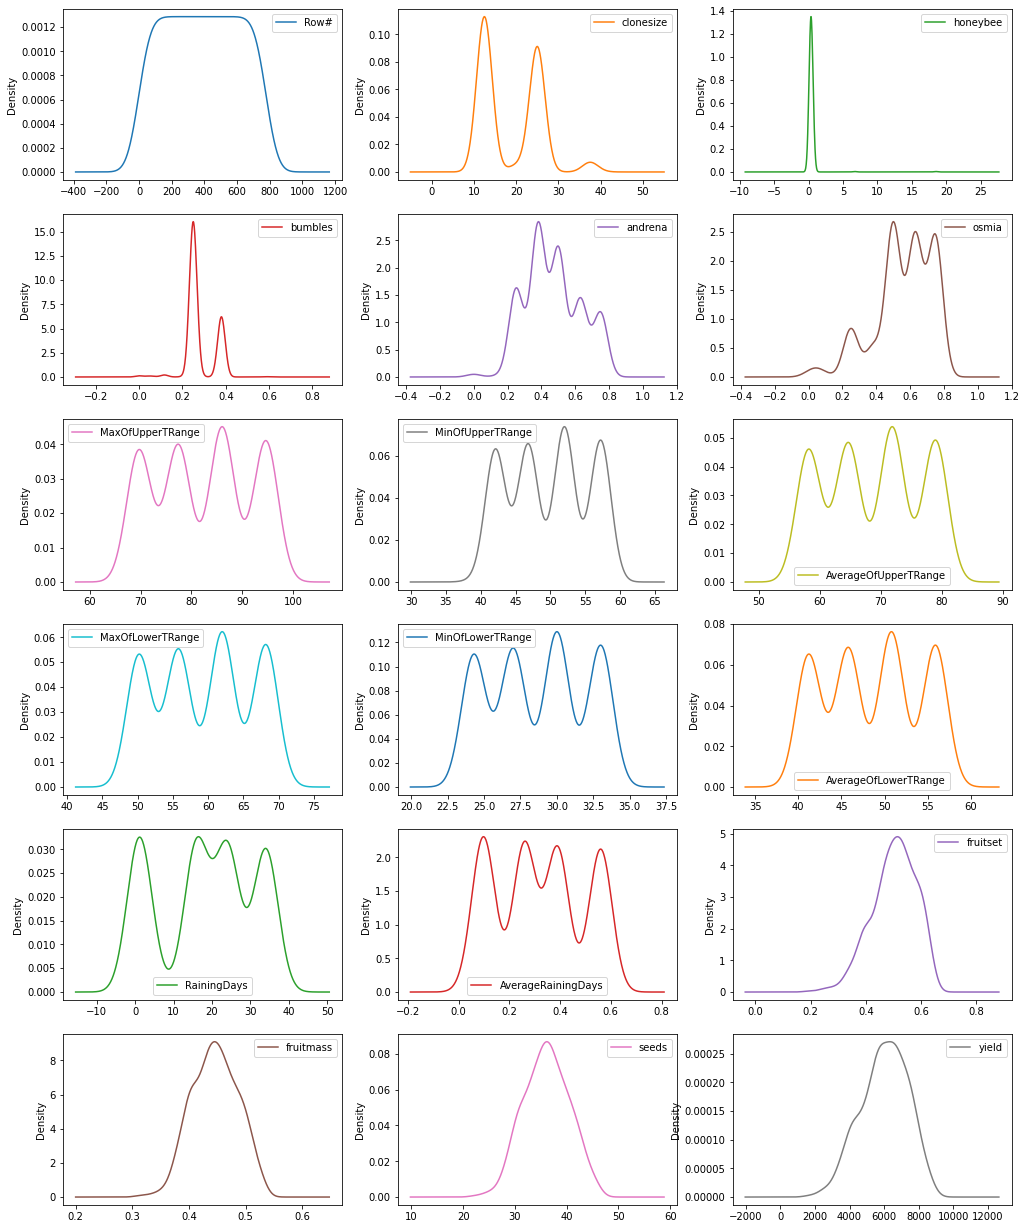

In [13]:
# unpivot = pd.melt(berry_data, berry_data.describe().columns[-1], berry_data.describe().columns[:-1])
# g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
# g.map(sns.kdeplot, "value")
# plt.show()

# ===================================================================================

# new method (one-liner)

berry_data.plot(kind="density", 
                subplots=True, 
                layout = (6,3), 
                figsize=(17,22), 
                sharex=False, 
                sharey=False);

# kind = density, histogram, boxplots

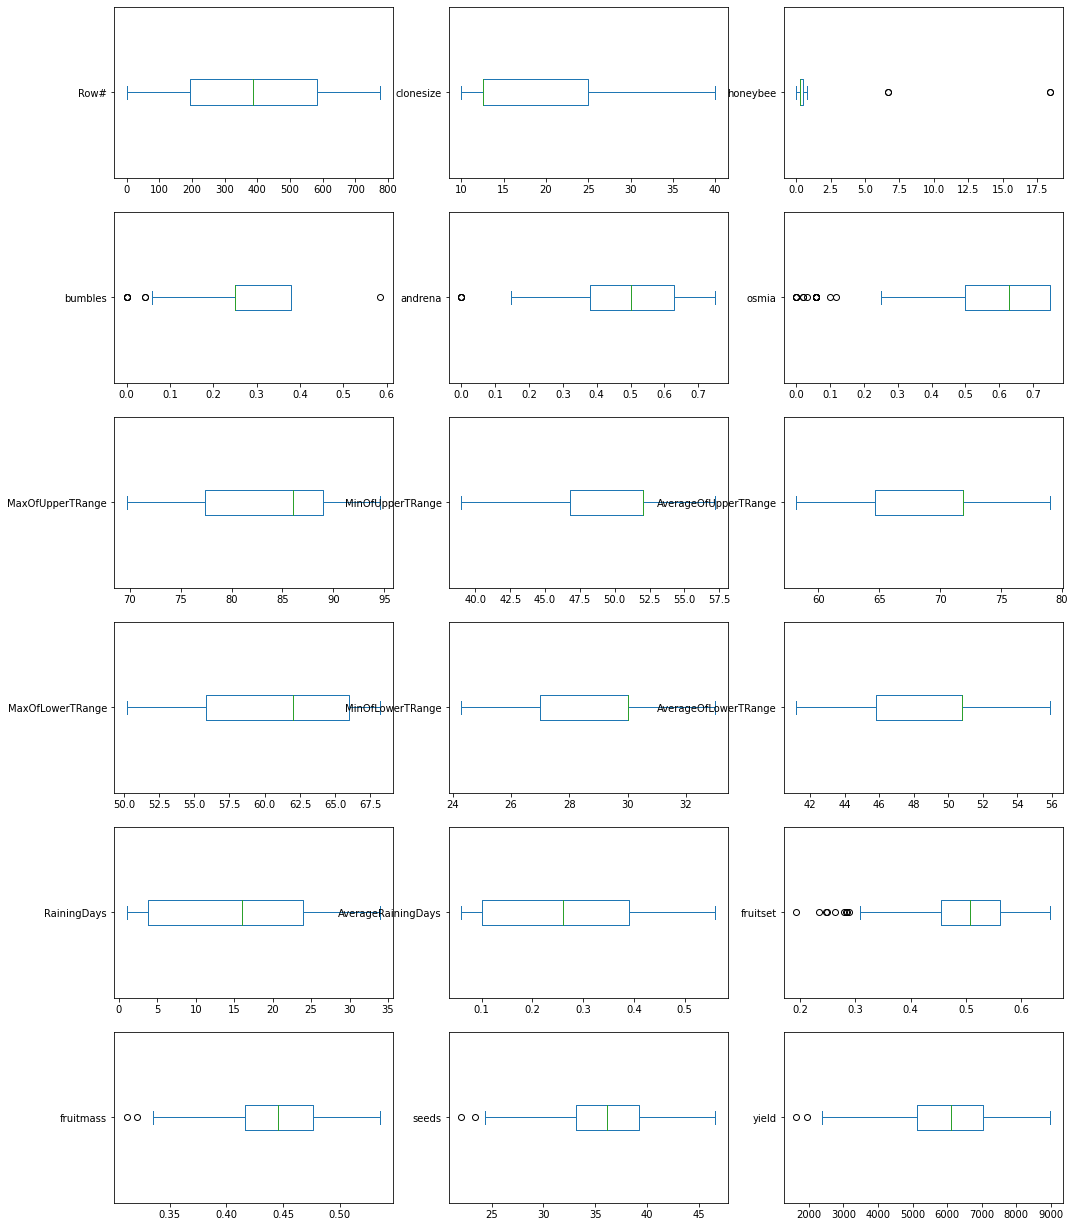

In [14]:
berry_data.plot(kind="box", 
                vert=False, # makes horizontal plots instead of vertical
                subplots=True, 
                layout = (6,3), 
                figsize=(17,22), 
                sharex=False, 
                sharey=False);

# Multivariate Analysis

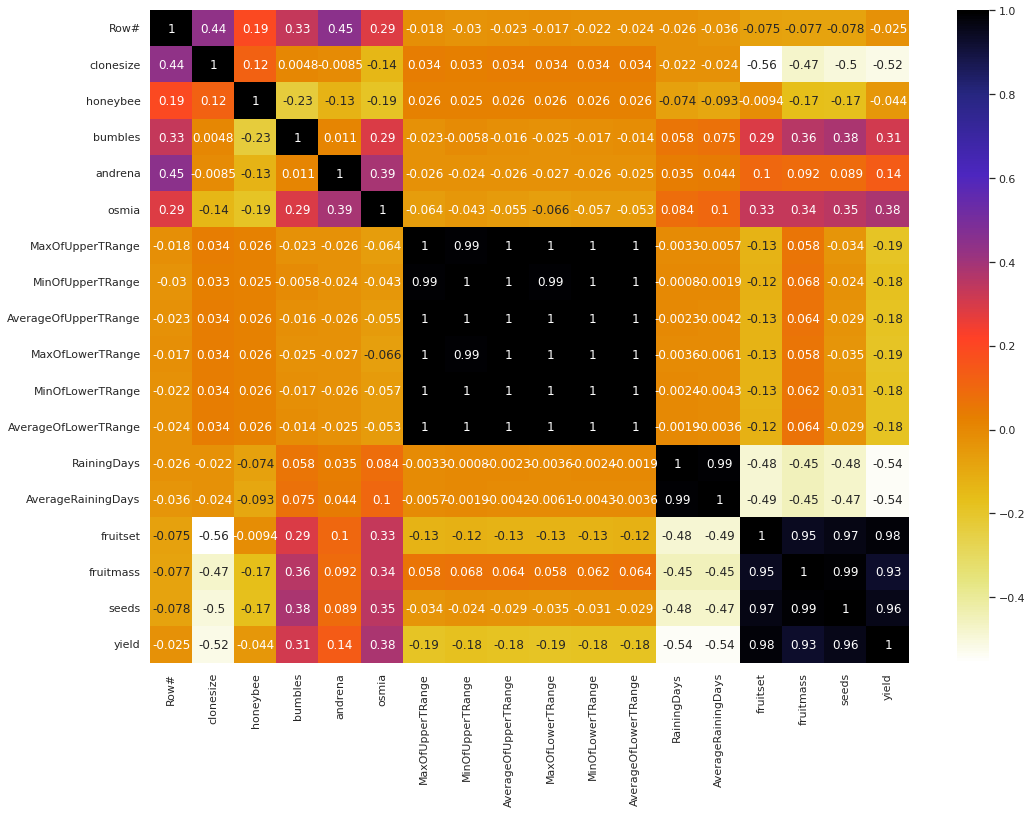

In [15]:
plt.figure(figsize=(17,12))
sns.set()
sns.heatmap(berry_data.corr(), annot=True, cmap=plt.cm.CMRmap_r)

# Preprocessing


columns to drop: 'Row#', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'RainingDays', 'honeybee'

We cannot keep fruitmass, fruitset and seeds as well. they are the derivatives of the output and cannot be considered for training.

In [16]:
berry_data.columns

Index(['Row#', 'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield'],
      dtype='object')

In [17]:
bbry_data_process = berry_data.drop(columns=['Row#', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'RainingDays', 'honeybee', "fruitset", "fruitmass", "seeds"])
bbry_data_process

,clonesize,bumbles,andrena,osmia,AverageOfUpperTRange,AverageOfLowerTRange,AverageRainingDays,yield
0,37.5,0.250,0.250,0.250,71.9,50.8,0.26,3813.165795
1,37.5,0.250,0.250,0.250,71.9,50.8,0.10,4947.605663
2,37.5,0.250,0.250,0.250,79.0,55.9,0.26,3866.798965
3,37.5,0.250,0.250,0.250,79.0,55.9,0.10,4303.943030
4,37.5,0.250,0.250,0.250,71.9,50.8,0.39,3436.493543
...,...,...,...,...,...,...,...,...
772,10.0,0.117,0.409,0.058,71.9,50.8,0.06,5333.873335
773,40.0,0.117,0.409,0.058,71.9,50.8,0.06,3373.436842
774,20.0,0.117,0.409,0.058,71.9,50.8,0.39,4203.027624
775,20.0,0.117,0.409,0.058,65.6,45.3,0.06,4166.299735


In [18]:
part1 = bbry_data_process.drop(columns=['yield'])
part2 = bbry_data_process[['yield']]
part1

,clonesize,bumbles,andrena,osmia,AverageOfUpperTRange,AverageOfLowerTRange,AverageRainingDays
0,37.5,0.250,0.250,0.250,71.9,50.8,0.26
1,37.5,0.250,0.250,0.250,71.9,50.8,0.10
2,37.5,0.250,0.250,0.250,79.0,55.9,0.26
3,37.5,0.250,0.250,0.250,79.0,55.9,0.10
4,37.5,0.250,0.250,0.250,71.9,50.8,0.39
...,...,...,...,...,...,...,...
772,10.0,0.117,0.409,0.058,71.9,50.8,0.06
773,40.0,0.117,0.409,0.058,71.9,50.8,0.06
774,20.0,0.117,0.409,0.058,71.9,50.8,0.39
775,20.0,0.117,0.409,0.058,65.6,45.3,0.06


In [19]:
Q1 = part1.quantile(0.25)
Q3 = part1.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

clonesize               12.50
bumbles                  0.13
andrena                  0.25
osmia                    0.25
AverageOfUpperTRange     7.20
AverageOfLowerTRange     5.00
AverageRainingDays       0.29
dtype: float64


In [20]:
bbry_data_iqr = bbry_data_process[~((bbry_data_process < (Q1 - 1.5 * IQR)) | (bbry_data_process > (Q3 + 1.5 * IQR))).any(axis=1)]
bbry_data_iqr.shape

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


(759, 8)

In [21]:
bbry_data_iqr

,clonesize,bumbles,andrena,osmia,AverageOfUpperTRange,AverageOfLowerTRange,AverageRainingDays,yield
0,37.5,0.25,0.25,0.25,71.9,50.8,0.26,3813.165795
1,37.5,0.25,0.25,0.25,71.9,50.8,0.10,4947.605663
2,37.5,0.25,0.25,0.25,79.0,55.9,0.26,3866.798965
3,37.5,0.25,0.25,0.25,79.0,55.9,0.10,4303.943030
4,37.5,0.25,0.25,0.25,71.9,50.8,0.39,3436.493543
...,...,...,...,...,...,...,...,...
754,25.0,0.38,0.63,0.50,64.7,45.8,0.10,7184.013843
755,25.0,0.38,0.63,0.50,58.2,41.2,0.26,6292.960756
756,25.0,0.38,0.63,0.50,58.2,41.2,0.10,6374.444297
757,25.0,0.38,0.63,0.50,64.7,45.8,0.39,6180.951419


Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


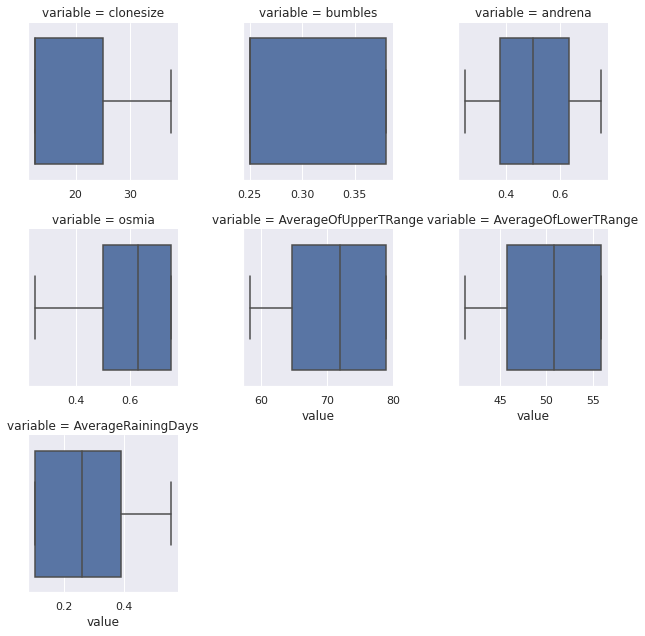

In [22]:
unpivot = pd.melt(bbry_data_iqr, bbry_data_iqr.describe().columns[-1], bbry_data_iqr.describe().columns[:-1])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.boxplot, "value")

plt.show()

In [23]:
z = np.abs(stats.zscore(bbry_data_process))
print(z)

     clonesize   bumbles   andrena     osmia  AverageOfUpperTRange  \
0     2.678126  0.488512  1.359549  1.846405              0.414096   
1     2.678126  0.488512  1.359549  1.846405              0.414096   
2     2.678126  0.488512  1.359549  1.846405              1.339534   
3     2.678126  0.488512  1.359549  1.846405              1.339534   
4     2.678126  0.488512  1.359549  1.846405              0.414096   
..         ...       ...       ...       ...                   ...   
772   1.253503  2.494523  0.371655  2.982429              0.414096   
773   3.035546  2.494523  0.371655  2.982429              0.414096   
774   0.176180  2.494523  0.371655  2.982429              0.414096   
775   0.176180  2.494523  0.371655  2.982429              0.407067   
776   0.176180  2.494523  0.371655  2.982429              0.407067   

     AverageOfLowerTRange  AverageRainingDays     yield  
0                0.403960            0.350531  1.622087  
1                0.403960            1.2852

In [24]:
bbry_data_zscore = bbry_data_process[(z < 3).all(axis=1)]
bbry_data_zscore.shape

(767, 8)

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


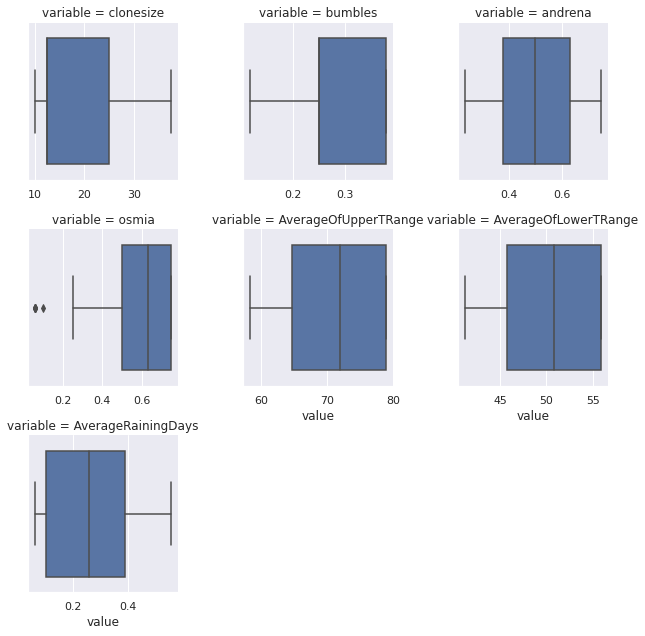

In [25]:
unpivot = pd.melt(bbry_data_zscore, bbry_data_zscore.columns[-1], bbry_data_zscore.columns[:-1])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.boxplot, "value")


plt.show()

In [26]:
bbry_data_process = bbry_data_zscore
bbry_data_process

,clonesize,bumbles,andrena,osmia,AverageOfUpperTRange,AverageOfLowerTRange,AverageRainingDays,yield
0,37.5,0.250,0.250,0.250,71.9,50.8,0.26,3813.165795
1,37.5,0.250,0.250,0.250,71.9,50.8,0.10,4947.605663
2,37.5,0.250,0.250,0.250,79.0,55.9,0.26,3866.798965
3,37.5,0.250,0.250,0.250,79.0,55.9,0.10,4303.943030
4,37.5,0.250,0.250,0.250,71.9,50.8,0.39,3436.493543
...,...,...,...,...,...,...,...,...
770,20.0,0.293,0.234,0.058,71.9,50.8,0.06,5449.421199
772,10.0,0.117,0.409,0.058,71.9,50.8,0.06,5333.873335
774,20.0,0.117,0.409,0.058,71.9,50.8,0.39,4203.027624
775,20.0,0.117,0.409,0.058,65.6,45.3,0.06,4166.299735


# Feature Selection

In [27]:
def select_features_corr_based(X_train, y_train, X_test, x="all"):
    if type(x) == str:
        fs_corr = SelectKBest(score_func=f_regression, k='all')
    else:
        fs_corr = SelectKBest(score_func=f_regression, k = x)
    fs_corr.fit(X_train, y_train)
    X_train_fs = fs_corr.transform(X_train)
    X_test_fs = fs_corr.transform(X_test)
    
    return X_train_fs, X_test_fs, fs_corr

def select_features_infogain_based(X_train, y_train, X_test, x="all"):
    if type(x) == str:
        fs_info = SelectKBest(score_func=mutual_info_regression, k='all')
    else:
        fs_info = SelectKBest(score_func=mutual_info_regression, k=x)
    fs_info.fit(X_train, y_train)
    X_train_fs = fs_info.transform(X_train)
    X_test_fs = fs_info.transform(X_test)
    
    return X_train_fs, X_test_fs, fs_info

In [28]:
X = bbry_data_process.drop(["yield"], axis=1)
y = bbry_data_process['yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

X_train_fs_corr, X_test_fs_corr, fs_corr = select_features_corr_based(X_train, y_train, X_test)
X_train_fs_info, X_test_fs_info, fs_info = select_features_infogain_based(X_train, y_train, X_test)

**I would have to perform many folds of tuning on the decided dataset, hence I would have to choose either one option of the below**

* info-gain vs correlation


The **KSelection score plot** describes a good behavior of the **Information Gain Values**.

Feature clonesize: 197.463675
Feature bumbles: 28.488060
Feature andrena: 7.497100
Feature osmia: 86.995221
Feature AverageOfUpperTRange: 16.802420
Feature AverageOfLowerTRange: 16.641514
Feature AverageRainingDays: 273.072671


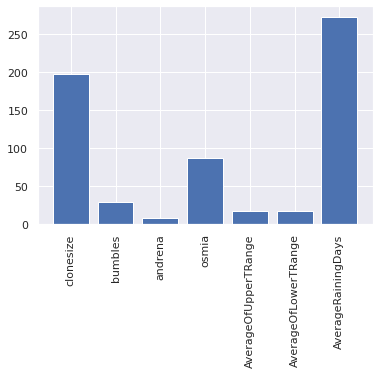

Feature clonesize: 0.164120
Feature bumbles: 0.022046
Feature andrena: 0.044388
Feature osmia: 0.104581
Feature AverageOfUpperTRange: 0.074052
Feature AverageOfLowerTRange: 0.073958
Feature AverageRainingDays: 0.219244


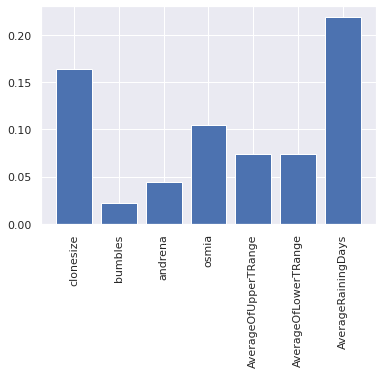

In [29]:
def fs_score_plot(fs_func):
    
    for i in range(len(fs_func.get_feature_names_out())):
        print('Feature %s: %f' % (fs_func.get_feature_names_out()[i], fs_func.scores_[i]))
    # plot the scores
    plt.bar(fs_func.get_feature_names_out(), fs_func.scores_)
    plt.xticks(rotation=90)
    plt.show()
    
fs_score_plot(fs_corr)
fs_score_plot(fs_info)

# Modelling 

<p style="font-size: 17px;"> <b> We will now train the model on top 9 features, using both the splits of dataset, <br>and check the metrics of the same on <span style="color: purple;"> 4 Models </span> </b></p>

* Linear Regression
* Random Forest
* Decision Tree
* XGBoost

In [30]:
X = bbry_data_process.drop(["yield"], axis=1)
y = bbry_data_process['yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

X_train_fs, X_test_fs, fs_info = select_features_infogain_based(X_train, y_train, X_test, x=7)

### LinearRegression

In [31]:
lreg = LinearRegression()

lreg.fit(X_train_fs, y_train)

yhat = lreg.predict(X_test_fs)

In [32]:
mae_linear = mean_absolute_error(y_test, yhat)
mse_linear = mean_squared_error(y_test, yhat)
rmse_linear = np.sqrt(mse_linear)
rsq_linear = r2_score(y_test, yhat)

print('MAE: %.3f' % mae_linear)
print('MSE: %.3f' % mse_linear)
print('RMSE: %.3f' % rmse_linear)
print('R-Square: %.3f' % rsq_linear)

MAE: 498.588
MSE: 362441.786
RMSE: 602.031
R-Square: 0.804


### RandomForest Regression

In [33]:
rf = RandomForestRegressor()

rf.fit(X_train_fs, y_train)
    
yhat = rf.predict(X_test_fs)

In [34]:
mae_rf = mean_absolute_error(y_test, yhat)
mse_rf = mean_squared_error(y_test, yhat)
rmse_rf = np.sqrt(mse_rf)
rsq_rf = r2_score(y_test, yhat)

print('MAE: %.3f' % mae_rf)
print('MSE: %.3f' % mse_rf)
print('RMSE: %.3f' % rmse_rf)
print('R-Square: %.3f' % rsq_rf)

MAE: 211.879
MSE: 74370.917
RMSE: 272.710
R-Square: 0.960


### Decision Tree Regression

In [35]:
dtree = DecisionTreeRegressor()

dtree.fit(X_train_fs, y_train)

yhat = dtree.predict(X_test_fs)

In [36]:
mae_dt = mean_absolute_error(y_test, yhat)
mse_dt = mean_squared_error(y_test, yhat)
rmse_dt = np.sqrt(mse_dt)
rsq_dt = r2_score(y_test, yhat)

print('MAE: %.3f' % mae_dt)
print('MSE: %.3f' % mse_dt)
print('RMSE: %.3f' % rmse_dt)
print('R-Square: %.3f' % rsq_dt)

MAE: 267.137
MSE: 128108.966
RMSE: 357.923
R-Square: 0.931


### XGBRegression

In [37]:
xgb = XGBRegressor()

xgb.fit(X_train_fs, y_train)

yhat = xgb.predict(X_test_fs)

[05:46:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [38]:
mae_xgb = mean_absolute_error(y_test, yhat)
mse_xgb = mean_squared_error(y_test, yhat)
rmse_xgb = np.sqrt(mse_dt)
rsq_xgb = r2_score(y_test, yhat)

print('MAE: %.3f' % mae_xgb)
print('MSE: %.3f' % mse_xgb)
print('RMSE: %.3f' % rmse_xgb)
print('R-Square: %.3f' % rsq_xgb)

MAE: 178.184
MSE: 52924.137
RMSE: 357.923
R-Square: 0.971


# Model Evaluation


<p style="font-size: 17px;"> We can also check the R<sup>2</sup> score. Here, we will be aiming to reduce the <br><b>RMSE</b> and <b> MAE </b> values</p>

The comparative BarPlot shows the values of each. We have **Linear Regression** (150.309) and **XGBoost** (145.976) at the lowest Error Rate

In [ ]:
# CV evaluation for all the models
# from sklearn.metrics import r2_score

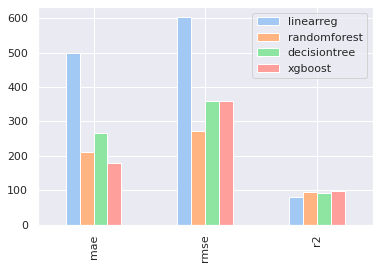

In [39]:
error_rec = {
    "linearreg": {
        "mae": mae_linear,
        "rmse": rmse_linear,
        'r2': rsq_linear*100
    },
    "randomforest": {
        "mae": mae_rf,
        "rmse": rmse_rf,
        'r2': rsq_rf*100
    },
    "decisiontree": {
        "mae": mae_dt,
        "rmse": rmse_dt,
        'r2': rsq_dt*100
    },
    "xgboost": {
        "mae": mae_xgb,
        "rmse": rmse_xgb,
        'r2': rsq_xgb*100
    },
}
pd.DataFrame(error_rec).plot(kind="bar", 
             color=[
                 sns.color_palette("pastel")[0], 
                 sns.color_palette("pastel")[1], 
                 sns.color_palette("pastel")[2], 
                 sns.color_palette("pastel")[3]]);


# Hyperparameter Tuning

crossvalidation, RepeatedKFold and GridSearchCV are the popular methods for Parameter Tuning

We have only tuned the model for K values, plus an addition model parameter. With greater processor, the tuning can afford to produce folds 3 times over 4 parameter values 
>Another alternative is:
> <span style="color: purple"><b> TuneSearchCV </b></span>

In [40]:
cv = RepeatedKFold(n_splits= 50, n_repeats = 3, random_state = 1)
fs_info_v0 = SelectKBest(score_func = mutual_info_regression)


# define pipeline for each algorithm
# define GSCV for each
# loop through it

# pipe = Pipeline ([(preprocessing: scaling), (FS: selectKBEST), (modelling: model)])


pipe_lr = Pipeline([
    ('sel', fs_info_v0), 
    ('model', LinearRegression())
])

pipe_rf = Pipeline([
    ('sel', fs_info_v0), 
    ('model', RandomForestRegressor(random_state=1))
])

pipe_dtree = Pipeline([
    ('sel', fs_info_v0), 
    ('model', DecisionTreeRegressor(random_state=1))
])

pipe_xgb = Pipeline([
    ('sel', fs_info_v0), 
    ('model', XGBRegressor(random_state=1))
])

# pipe_lr.get_params().keys()

In [41]:

grid_params_lr = [{'sel__k': [i for i in range(X_train_fs.shape[1]-6, X_train_fs.shape[1]-4)],
        }] 


grid_params_rf = [{'sel__k': [i for i in range(X_train_fs.shape[1]-6, X_train_fs.shape[1]-4)],
        'model__max_depth': [15, 18, 10],
        'model__min_samples_split': [15, 18, 10]
                  }]


grid_params_dtree = [{'sel__k': [i for i in range(X_train_fs.shape[1]-6, X_train_fs.shape[1]-4)],
                     'model__max_depth': [15, 18, 10],
                     'model__max_features': ['auto', 'sqrt']
                     }]


grid_params_xgb = [{'sel__k': [i for i in range(X_train_fs.shape[1]-6, X_train_fs.shape[1]-4)],
                    'model__max_depth': [9,12],
                   'model__min_child_weight': [7,8],
                   'model__subsample': [i/10. for i in range(9,11)]
                   }]


# estimator (model), parameter (model), scoring

# def custom_metric(values):
#     #calculate metric
#     return metric_value

LR = GridSearchCV(estimator=pipe_lr,
            param_grid=grid_params_lr,
            scoring='neg_mean_absolute_error',
            cv=cv)

RF = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_rf,
            scoring='neg_mean_absolute_error',
            cv=cv, 
            n_jobs= -1)

DT = GridSearchCV(estimator=pipe_dtree,
            param_grid=grid_params_dtree,
            scoring='neg_mean_absolute_error',
            cv=cv, 
            n_jobs= -1)

XGB = GridSearchCV(estimator=pipe_xgb,
            param_grid=grid_params_xgb,
            scoring='neg_mean_absolute_error',
            cv=cv, 
            n_jobs= -1)

grids = [LR,RF,XGB,DT]

# Creating a dict for our reference
grid_dict = {0: 'Linear Regression', 
        1: 'Random Forest',
        2: 'XGBoost',
        3: 'Decision Tree'}

In [ ]:
# store the error values in a dataframe and plot as evaluation visualization also see boosted DTree and R2 square values

In [42]:
# Start form initial scaled model: X_train17 and X_test17, y_train17 and y_test17
def extract_best_model(grids: list, grid_dict: dict):
    print('Performing model optimizations...')
    least_mae = 270817
    best_regr = 0
    best_gs = ''
    for idx, gs in enumerate(grids):
        print('\nEstimator: %s' % grid_dict[idx])
        gs.fit(X_train_fs, y_train)
        print('Best Config: %s' % gs.best_params_)
        # Best training data accuracy
        print('Best MAE: %.3f' % gs.best_score_)
        # Predict on test data with best params
        y_pred_v0 = gs.predict(X_test_fs)
        # Test data accuracy of model with best params
        print('Test set mean absolute error for best params: %.3f ' % mean_absolute_error(y_test, y_pred_v0))
        print('Test set root mean squared error for best params: %.3f ' % np.sqrt(mean_absolute_error(y_test, y_pred_v0)))
        
        # Track best (least test error) model
        if mean_absolute_error(y_test, y_pred_v0) < least_mae:
            least_mae = mean_absolute_error(y_test, y_pred_v0)
            best_gs = gs
            best_regr = idx
    print('\nClassifier with least test set MAE: %s' % grid_dict[best_regr])

    
    return (grid_dict[best_regr], best_gs, least_mae)

# Prediction and Evaluation

**Running the GridSearchCV and saving the best model.**

<p style="font-size: 17px;"> Although Linear Regression is the best of the listed models, <b>RandomForest</b> would potentially produce closer precise results, due to good learning rate, hence I would retune it in addition to the best params extracted in the first search </p>

In [44]:
best_model_name_v0, best_model_v0, least_mae_v0 = extract_best_model(grids= grids, grid_dict = grid_dict)

print(f"Best Model: {best_model_name_v0}")
print(f"Error Rate: {least_mae_v0}")
print(best_model_v0)

Performing model optimizations...

Estimator: Linear Regression
Best Config: {'sel__k': 2}
Best MAE: -642.950
Test set mean absolute error for best params: 691.125 
Test set root mean squared error for best params: 26.289 

Estimator: Random Forest
Best Config: {'model__max_depth': 15, 'model__min_samples_split': 10, 'sel__k': 2}
Best MAE: -619.934
Test set mean absolute error for best params: 649.424 
Test set root mean squared error for best params: 25.484 

Estimator: XGBoost
[05:58:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Config: {'model__max_depth': 9, 'model__min_child_weight': 7, 'model__subsample': 1.0, 'sel__k': 2}
Best MAE: -620.696
Test set mean absolute error for best params: 653.565 
Test set root mean squared error for best params: 25.565 

Estimator: Decision Tree
Best Config: {'model__max_depth': 15, 'model__max_features': 'auto', 'sel__k': 2}
Best MAE: -613.074
Test set mean absolute er

In [51]:
grid_params_rf1 = [{
        'model__max_depth': [1, 3, 5, 10],
        'model__min_samples_split': [2,5]
                  }]

RF1 = GridSearchCV(
    estimator = Pipeline([
                    ('sel', SelectKBest(score_func=mutual_info_regression, k='all')), 
                    ('model', RandomForestRegressor(random_state=1, criterion='mse'))
                ]),
            param_grid=grid_params_rf1,
            scoring='neg_mean_absolute_error',
            cv=cv, 
            n_jobs= -1)


print("Random Forest V-1 optimising...")
RF1.fit(X_train_fs, y_train)
print('Best Config: %s' % RF1.best_params_)
print('Best MAE: %.3f' % RF1.best_score_)
y_pred_v1_rf1 = RF1.predict(X_test_fs)
print('Test set mean absolute error for best params: %.3f ' % mean_absolute_error(y_test, y_pred_v1_rf1))
print('Test set root mean squared error for best params: %.3f ' % np.sqrt(mean_absolute_error(y_test, y_pred_v1_rf1)))
        

Random Forest V-1 optimising...
Best Config: {'model__max_depth': 10, 'model__min_samples_split': 2}
Best MAE: -213.754
Test set mean absolute error for best params: 207.558 
Test set root mean squared error for best params: 14.407 


Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.


### Save the models for backup in pickle files

# Model Explainability (Explainable AI)

we have two models `RF1` and `best_model_v0` which is random forest and xgboost trained on the test set. we will visualize the model behavior and explainability.

[Shap Tree Explainer](https://shap.readthedocs.io/en/stable/example_notebooks/tabular_examples/tree_based_models/Fitting%20a%20Linear%20Simulation%20with%20XGBoost.html) has the code docs

In [53]:
# in the above cells, fit the model with the returned params from the gsearchCV
# and then passit to the shap arguements

fs_rf = SelectKBest(score_func=mutual_info_regression, k='all')
fs_rf.fit(X_train,y_train)
X_train_rf = fs_rf.transform(X_train)
X_test_rf = fs_rf.transform(X_test)
rf_final = RandomForestRegressor(max_depth = 15, min_samples_split = 2, criterion = 'mse')

rf_final.fit(X_train_rf, y_train)
rf_pred = rf_final.predict(X_test_rf)

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.


In [54]:
print(mean_absolute_error(y_test, rf_pred))
print(np.sqrt(mean_squared_error(y_test, rf_pred)))

212.1774164685366
276.1787444929474


In [55]:
# fs.get_support() will return boolean values in a list, with True at the 'k' specific selected features

feature_columns = [X.columns[i] for i in range(len(fs_rf.get_support())) if fs_rf.get_support()[i]]
feature_columns

['clonesize',
 'bumbles',
 'andrena',
 'osmia',
 'AverageOfUpperTRange',
 'AverageOfLowerTRange',
 'AverageRainingDays']

In [56]:
# using the above line of code to create a dataframe
# fs.transform will return the np.array() values and fs.get_support() will have the columns

pd.DataFrame(X_test_rf, columns=[X.columns[i] for i in range(len(fs_rf.get_support())) if fs_rf.get_support()[i]])

,clonesize,bumbles,andrena,osmia,AverageOfUpperTRange,AverageOfLowerTRange,AverageRainingDays
0,12.5,0.25,0.63,0.63,58.2,41.2,0.26
1,12.5,0.25,0.25,0.63,79.0,55.9,0.26
2,25.0,0.25,0.63,0.63,64.7,45.8,0.39
3,12.5,0.25,0.75,0.75,64.7,45.8,0.56
4,25.0,0.25,0.75,0.63,58.2,41.2,0.56
...,...,...,...,...,...,...,...
249,25.0,0.25,0.38,0.75,79.0,55.9,0.26
250,25.0,0.25,0.25,0.38,64.7,45.8,0.10
251,25.0,0.25,0.25,0.25,79.0,55.9,0.39
252,25.0,0.25,0.75,0.50,71.9,50.8,0.26


In [57]:
# Creating dataframe for test set of attributes, so that feature columns can be visible in the plot

X_test_rf_df = pd.DataFrame(X_test_rf, columns=[X.columns[i] for i in range(len(fs_rf.get_support())) if fs_rf.get_support()[i]])

shap_values = shap.TreeExplainer(rf_final).shap_values(X_test_rf_df)
shap_interaction_values = shap.TreeExplainer(rf_final).shap_interaction_values(X_test_rf_df)

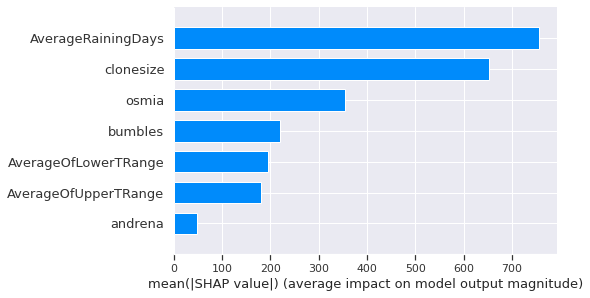

In [58]:
# summary plot of XGB test set as the impact value
shap.summary_plot(shap_values, X_test_rf_df, plot_type="bar")

We can see if the **fruitset value decreases, it doesn't affect the yield value**,
while if it **increases**, it will **overpower** the other impacts

**Other features** has comparitively ***high*** tolerance value. If there is -1 rainy days, then it will have a higher value, while for **range of +/-2**, the impact drops ***low***

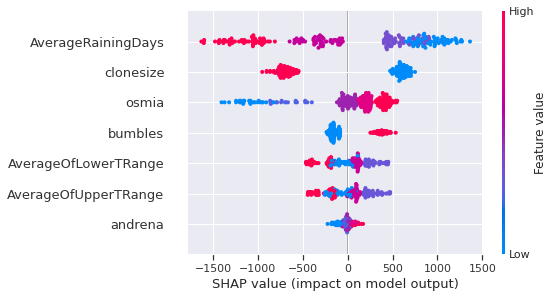

In [59]:
# BeeSwarm plot of the features based on impact on specific values

shap.summary_plot(shap_values, X_test_rf_df)

In [60]:
shap.initjs()

shap.force_plot(shap.TreeExplainer(rf_final).expected_value, shap_values[50,0:-3], X_test_rf_df.iloc[50,0:-3])

### From the data of  <span style="color: forestgreen;">105 to 150 +/- 30</span>, the test set values have balanced impact on the yield, otherwise, it is overpowerd by the fruitset value or the other

In [61]:
shap.force_plot(shap.TreeExplainer(rf_final).expected_value, shap_values[0:257,:], X_test_rf_df.iloc[0:257,:])

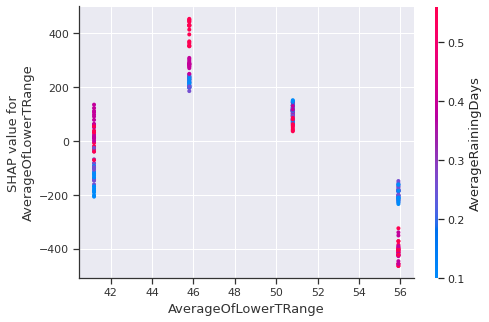

In [62]:
shap.dependence_plot(5, shap_values, X_test_rf_df) # should be 1-7 as we have 8 features

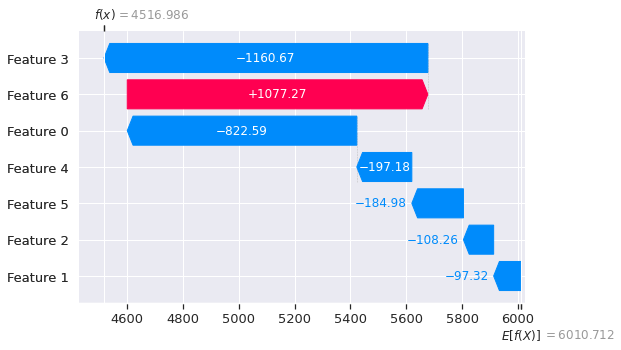

In [63]:
row = 111
shap.plots._waterfall.waterfall_legacy(shap.TreeExplainer(rf_final).expected_value[0], shap_values[row])

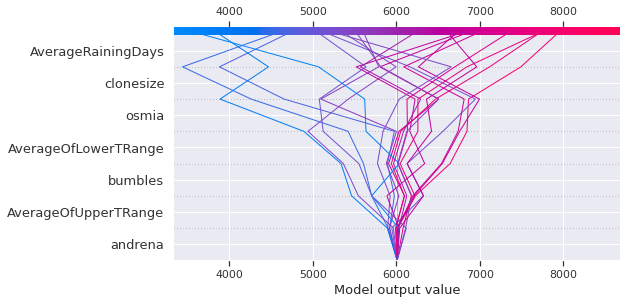

In [64]:
shap.decision_plot(shap.TreeExplainer(rf_final).expected_value[0], shap_values[110:130], feature_columns)

# Saving Models and Backup Objects



In [65]:
# Save best grid search pipeline to file
dump_file_name = 'lreg_bbry_tuned_model.pkl'
joblib.dump(best_model_v0, dump_file_name, compress=1)
print('\nSaved %s tuned model to directory by name: %s' % (best_model_name_v0, dump_file_name))
    
# Save the random forest grid search pipleline for backup
dump_file_name1 = 'rf_bbry_tuned_model.pkl'
joblib.dump(rf_final, dump_file_name1, compress=1)
print('\nSaved %s tuned model to directory by name: %s' % ("Random Forest", dump_file_name1))


Saved Random Forest tuned model to directory by name: lreg_bbry_tuned_model.pkl

Saved Random Forest tuned model to directory by name: rf_bbry_tuned_model.pkl


In [66]:
# # Save feature selection objects for backup
joblib.dump(fs_rf, "rf_fs_object.joblib", compress=1)
print("\n Saved %s to %s" % ("Randomforest fs object", "rf_fs_object.joblib"))


X_test_rf_df.to_csv("X_test_rf_df.csv")
print("\nSaved X_test for RF to CSV")

joblib.dump(X_train_rf, "X_train_rf.joblib")
print("\n Saved X_train for RF to joblib file")



 Saved Randomforest fs object to rf_fs_object.joblib

Saved X_test for RF to CSV

 Saved X_train for RF to joblib file


In [71]:
pd.read_csv("/content/X_test_rf_df.csv", index_col=0).iloc[110].values

array([2.00e+01, 2.93e-01, 2.34e-01, 5.80e-02, 7.19e+01, 5.08e+01,
       6.00e-02])

In [72]:
# # Save the target test set
joblib.dump(y_test, "y_test.joblib", compress=1)
print("\nSaved y_test to joblib file")


Saved y_test to joblib file


<Figure size 648x936 with 0 Axes>

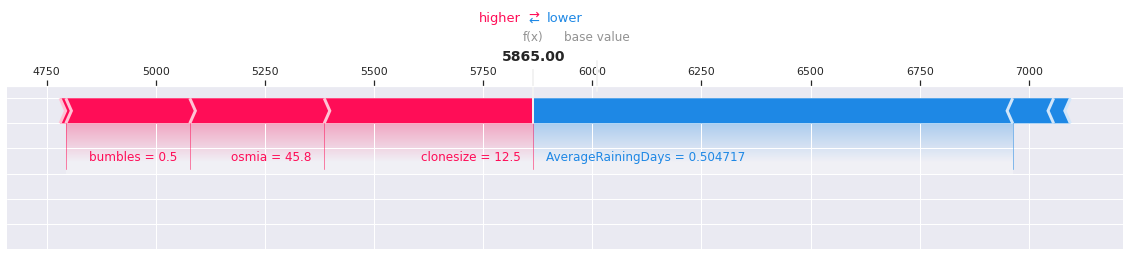

In [73]:
# # Saving png plot image. bbox_inches='tight' will prevent cropping the image

plt.figure(figsize=(9,13))
shap.force_plot(shap.TreeExplainer(rf_final).expected_value, #pass the model
                shap.TreeExplainer(rf_final).shap_values(np.array([12.5, 0.50, 64.7, 45.8, 0.26, 0.611463, 0.504717, 42.508522]).reshape(1,-1)), #pass query, will give the prediction
                np.array([12.5, 0.50, 64.7, 45.8, 0.26, 0.611463, 0.504717, 42.508522]).reshape(1,-1),
                feature_names=feature_columns,
               show=False,
               matplotlib=True).savefig("test_force_plot1.png", bbox_inches = 'tight') # pass the query in form of dataframe